# BYOL Pretraining for Surgical Phase Recognition
**Self-Supervised Contrastive Learning on Endoscopic Pituitary Surgery**

This notebook implements the BYOL framework to pretrain a ResNet-50 model encoder using contrastive learning.

Bootstrap Your Own Latent (BYOL) is a self-supervised learning (SSL) method that focuses on training representations without relying on negative samples, which is a key difference from contrastive methods like SimCLR. Instead, it directly minimizes the similarity of representations of the same image under a different augmented view (positive pair). Negative samples are images from the batch other than the positive pair. BYOL introduces a dual-network structure: a student network (online network) and a teacher network (target network). Here are the key components of the BYOL approach:

- Stochastic data augmentation to create positive pairs `x_i` and `x_j`
- Student (Online) Network: This network consists of a backbone (e.g., ResNet-50) `f(.)` and two MLP heads: one for projection `g(.)` and another for prediction `q(.)`.
- Teacher (Target) Network: The target network is essentially a copy of the student network, but its parameters are updated through Exponential Moving Average (EMA) based on the student’s parameters. This prevents gradients from directly flowing through the target network.
- Asymmetry between Student and Teacher: The key innovation in BYOL is the asymmetric architecture where only the student has a predictor MLP, while the teacher network doesn’t. This asymmetry helps prevent mode collapse, where the model would otherwise produce the same representation for all inputs.
- The loss function is based on the mean squared error (MSE) between the L2-normalized outputs of the student and the teacher networks for two augmented views of the same image.

    - The weights of the teacher network are updated using EMA: $teacher params = 𝛼×teacher params+(1−𝛼)×student params$ where $𝛼$ is typically set to a value close to 1 (e.g., 0.99). This slow update of the teacher network ensures that it evolves smoothly from the student’s weights, leading to stable training.


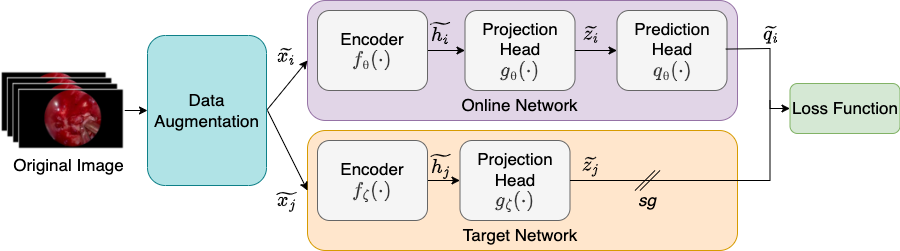

### Imports

In [ ]:
from __future__ import print_function, division
import os
import torch
import torchvision
import pandas as pd
from skimage import io, transform, util
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torchvision import transforms, models, utils
from PIL import Image
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

## 1. Data Augmentation for Contrastive Learning

In [2]:
class ContrastiveTransformations:
    """
    A stochastic data augmentation module
    Transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # Convert NumPy array to PIL Image if necessary
        if isinstance(image, np.ndarray):
            image_pil = Image.fromarray(image)
        else:
            image_pil = image

        # Apply base transformations to create two views
        transformed_images = [self.base_transforms(image_pil) for _ in range(self.n_views)]
        
        return {'image': transformed_images, 'label': label}

In [ ]:
# Define BYOL augmentations
byol_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.6, 
                                                   contrast=0.4, 
                                                   saturation=0.5, 
                                                   hue=0.5)], p=0.6),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.6),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.312, 0.120, 0.117], std=[0.280, 0.158, 0.160])])

contrastive_augment = ContrastiveTransformations(byol_transform, n_views=2)

## 2. BYOL Implementation

### Load dataset

In [3]:
class PituDataset(Dataset):
    """Pituitary Endoscopy dataset."""

    def __init__(self, csv_file, root_dir, transform=None, maxSize=0, unlabeled=False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            maxSize (int, optional): Maximum size of the dataset (number of samples).
            unlabeled (bool, optional): If True, ignore labels.
        """
        self.dataset = pd.read_csv(csv_file, header=0, dtype={'id': str, 'label': int})
        
        if maxSize > 0:
            newDatasetSize = maxSize  # maxSize samples (Parameter to select a specific number of images)
            idx = np.random.RandomState(seed=42).permutation(range(len(self.dataset)))
            reduced_dataset = self.dataset.iloc[idx[0:newDatasetSize]]
            self.dataset = reduced_dataset.reset_index(drop=True)

        self.root_dir = root_dir
        self.img_dir = os.path.join(root_dir, 'images')
        self.transform = transform
        self.unlabeled = unlabeled
        self.classes = ['Desconocida', 'Preparacion colgajo', 'Etmoidectomia', 'Apertura selar', 
                        'Apertura dural', 'Reseccion tumoral', 'Cierre']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Read the image
        img_name = os.path.join(self.img_dir, self.dataset.id[idx] + '.png')
        image = io.imread(img_name)
        
        if self.unlabeled:
            sample = {'image': image, 'label': np.int64(-1)}  # Use -1 to indicate unlabeled, keep datatype
        else:
            sample = {'image': image, 'label': self.dataset.label[idx].astype(dtype=np.long)}
        
        if self.transform:
            sample = self.transform(sample)
        return sample 

In [4]:
# Train Dataset
unlabeled_train_dataset = PituDataset(csv_file="/home/train_set.csv",
                                      root_dir='/home',
                                      #maxSize=100000,
                                      transform=contrastive_augment,
                                      unlabeled=True)

# Validation Dataset
val_dataset = PituDataset(csv_file="/home/acenteno/val_set.csv",
                          root_dir='/home',
                          transform=contrastive_augment)

Images in train dataset: 213907
Images in validation dataset: 56431


### Define BYOL Class

In [7]:
# Define the MLP used in the projection head p(·) and predictor q(·)
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim=4096, projection_size=512):
        super().__init__()
        # The MLP consists of Linear->BN->ReLU->Linear
        self.net = nn.Sequential( 
            nn.Linear(dim, hidden_dim), # Linear(backbone.fc.in_features = 2048, 4096) (entra h)
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, projection_size) # Linear(4096, 512) (sale z)
        )
    
    def forward(self, x):
        return self.net(x)

In [9]:
def L2_loss(x, y):
    x = F.normalize(x, dim=1)
    y = F.normalize(y, dim=1)
    return 2 - 2 * (x * y).sum(dim=-1)

In [12]:
# Define the BYOL model
class BYOL(pl.LightningModule):
    """
    BYOL (Bootstrap Your Own Latent) implementation.

    This class defines the architecture and training process for a self-supervised learning
    model, allowing it to learn useful representations without using labeled data.
    """
    
    def __init__(self, hidden_dim, projection_size, lr, momentum, weight_decay, moving_average_decay):
        super().__init__()
        """
        Args:
            hidden_dim (int): The size of the hidden vector in the MLPs of the student and teacher projection heads.
            projection_size (int): The size of the output vector from the projection head (dimension of the embedding space).
            lr (float): Learning rate for the optimizer.
            momentum (float): Momentum parameter for the SGD optimizer.
            weight_decay (float): Weight decay for L2 regularization.
            moving_average_decay (float): Decay factor for the exponential moving average used to update the teacher model. e.g. 0.99
        """
        self.save_hyperparameters()
        
        # Base encoder f(.): ResNet-50
        self.backbone = torchvision.models.resnet50()
        in_features = self.backbone.fc.in_features  # 2048 for ResNet-50 (this is vector h)
        self.backbone.fc = nn.Identity()  # Remove the final classification layer to get the feature vector
        
        # Projection head g(·) --> consists of Linear->BN->ReLU->Linear
        self.student_projector = MLP(in_features, hidden_dim, projection_size) #(2048,4096,512)
        
        # Prediction head q(·)
        self.student_predictor = MLP(projection_size, hidden_dim, projection_size)  #(512,4096,512) (output vector q)
        
        # Teacher model
        self.teacher_projector = copy.deepcopy(self.student_projector)
        
        # EMA parameters
        self.moving_average_decay = moving_average_decay
        
   
    def configure_optimizers(self):
        '''optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        '''
        optimizer = optim.SGD(self.parameters(),
                              lr=self.hparams.lr,
                              weight_decay=self.hparams.weight_decay,
                              momentum=self.hparams.momentum)
        
        
        return optimizer


    @torch.no_grad()
    def update_moving_average(self):
        """
        Updates the weights of the teacher model as a moving average of the student model's weights.
        """
        for student_params, teacher_params in zip(self.student_projector.parameters(), self.teacher_projector.parameters()):
            teacher_params.data = teacher_params.data * self.moving_average_decay + (1. - self.moving_average_decay) * student_params.data
          
        
    def initializes_target_network(self):
        '''
        Initializes the target (teacher) network with the same weights as the student model.
        Ensures the teacher's parameters do not require gradient updates.
        '''
        
        for student_params, teacher_params in zip(self.student_projector.parameters(), self.teacher_projector.parameters()):
            teacher_params.data.copy_(student_params.data)  # initialize
            teacher_params.requires_grad = False  # not update by gradient
            
    
    def on_train_start(self):
        # Initialize the teacher network at the start of training
        self.initializes_target_network()


    def forward(self, x):
        '''
        Forward pass through the student network and student projector
        '''
        features = self.backbone(x)
        student_projection = self.student_projector(features)
        student_prediction = self.student_predictor(student_projection)
        return student_prediction
    

    def shared_step(self, img1, img2):
    
        # get student projections: backbone + MLP projection head
        feats1 = self.backbone(img1) #this is h
        feats2 = self.backbone(img2)
        
        student_proj1 = self.student_projector(feats1) #this is g
        student_proj2 = self.student_projector(feats2)

        # Apply the predictor MLP to the student's projections
        student_pred1 = self.student_predictor(student_proj1) # this is q
        student_pred2 = self.student_predictor(student_proj2)

        # Get teacher projections (no gradient updates)
        with torch.no_grad():
            # teacher processes the images and makes projections: backbone + MLP
            teacher_proj1 = self.teacher_projector(feats1) 
            teacher_proj2 = self.teacher_projector(feats2)
        
        # calculate loss
        loss = L2_loss(student_pred1, teacher_proj2)
        loss += L2_loss(student_pred2, teacher_proj1)        

        return loss.mean() #loss = (loss1 + loss2).mean()

    
    def training_step(self, batch, batch_idx):
        img1, img2 = batch['image'][0], batch['image'][1]
        img1 = img1.to(device=device, dtype=torch.float)
        img2 = img2.to(device=device, dtype=torch.float)

        loss = self.shared_step(img1, img2)
        self.log('train_loss', loss)

        # Update the teacher model
        self.update_moving_average()
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        img1, img2 = batch['image'][0], batch['image'][1]
        img1 = img1.to(device=device, dtype=torch.float)
        img2 = img2.to(device=device, dtype=torch.float)

        loss = self.shared_step(img1, img2)
        self.log('val_loss', loss)
                
        return loss

### Pre-Training 


In [22]:
def train_byol(batch_size, max_epochs=5, **kwargs):
    trainer = pl.Trainer(default_root_dir='/home/byol_models',
                         accelerator="gpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_loss'),
                                    LearningRateMonitor('epoch'), EarlyStopping(monitor="val_loss", patience=3, mode="min")])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    train_loader = DataLoader(unlabeled_train_dataset, batch_size=batch_size, shuffle=True, 
                                    drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                    drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    pl.seed_everything(42) # To be reproducable

    
    # Initialize the BYOL model
    byol_model = BYOL(hidden_dim=4096, 
                        projection_size=512,
                        lr=0.03, 
                        momentum=0.9,
                        weight_decay=0.0004,
                        moving_average_decay=0.996)
    
    trainer.fit(byol_model, train_loader, val_loader)
    
    model = BYOL.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

In [26]:
byol_model = train_byol(batch_size=64, 
                        hidden_dim=4096, 
                        projection_size=512,
                        lr=0.03, 
                        momentum=0.9,
                        weight_decay=0.0004,
                        moving_average_decay=0.996,
                        max_epochs=100)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | backbone          | ResNet     | 25.6 M
1 | student_encoder   | Sequential | 23.5 M
2 | student_projector | MLP        | 10.5 M
3 | student_predictor | MLP        | 4.2 M 
4 | teacher_encoder   | Sequential | 23.5 M
5 | teacher_projector | MLP        | 10.5 M
-------------------------------------------------
74.3 M    T

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


Total training time: 167.96 minutes


In [ ]:
# Save the model
save_dir = '/home/byol_models'
os.makedirs(save_dir, exist_ok=True)

# Define the path 
save_path = os.path.join(save_dir, 'byol_model.pt')

# Save the model's state dictionary
torch.save(simclr_model.state_dict(), save_path)

print(f"Best model saved to {save_path}")